In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [2]:

def stack_lab(l, ab):
  return torch.cat((l, ab))

def lab2rgb(lab, to_numpy):
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy().permute(2,0,1)

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using CIFAR100

In [3]:
class ColorizationDataset(Dataset):
    def __init__(self,root='./data', train=True, resize=None):
        self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True)
        self.resize = resize

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, index):
        image, label = self.cifar100[index]
        if self.resize:
          image = image.resize((self.resize, self.resize))

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))

        return L, ab

In [4]:
train_data = ColorizationDataset(
    root='./data',
    train=True,
    resize = None
)

test_data = ColorizationDataset(
    root='./data',
    train=False,
    resize = None
)
len(train_data), len(test_data)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [5]:
gray, chrome = train_data[69]
gray.shape, chrome.shape

(torch.Size([1, 32, 32]), torch.Size([2, 32, 32]))

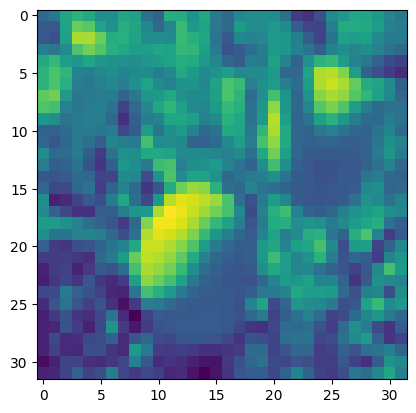

In [6]:
plt.imshow(gray[0])

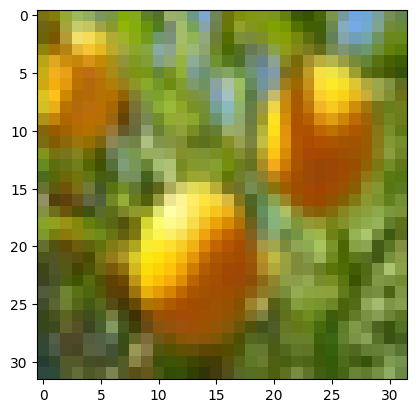

In [7]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

## 2. from kaggle colorization dataset

In [8]:

# train_path = "/content/drive/MyDrive/colorization-data/data/train_color"
# test_path = "/content/drive/MyDrive/colorization-data/data/test_color"





# II. Preparing the Model

In [36]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # print(x.shape)
        x = nn.LeakyReLU(.2)(self.conv1(x))
        x = nn.LeakyReLU(.2)(self.conv2(x))
        x = self.bn(x)
        return x


In [37]:
class DecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) 
        self.conv = DoubleConv(out_channels + out_channels, out_channels)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1), dim=-3)
        y = self.conv(y2)
        return y

In [38]:
class UNet(nn.Module):
    def __init__(self, size):
        super().__init__()

        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # trainable layers
        ## encoder 
        self.en_conv1 = DoubleConv(1,size)
        self.en_conv2 = DoubleConv(size,size*2)
        self.en_conv3 = DoubleConv(size*2,size*4)
        self.en_conv4 = DoubleConv(size*4,size*8)
        
        ## bottleneck
        self.conv = DoubleConv(size*8,size*16)
        self.drop = nn.Dropout(0.5)

        ## decoder
        self.de_conv4 = DecoderConv(size*16,size*8)
        self.de_conv3 = DecoderConv(size*8,size*4)
        self.de_conv2 = DecoderConv(size*4,size*2)
        self.de_conv1 = DecoderConv(size*2,size)
        
        ## reconstruct layer
        self.reconstruct = nn.Conv2d(size, 2, kernel_size=3, padding=1)

    def forward(self, x):
      # encoder inference 
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        
        e3 = self.en_conv3(p2) 
        p3 = self.pool(e3)
        
        e4 = self.en_conv4(p3)
        p4 = self.pool(e4)

      # bottleneck inference
        b = self.drop(self.conv(p4))

      # decoder inference 
        d4 = self.de_conv4(b,e4)

        d3 = self.de_conv3(d4,e3)

        d2 = self.de_conv2(d3,e2)

        d1 = self.de_conv1(d2,e1)



      # reconstruct image
        colored_image = self.reconstruct(d1)
        # print(colored_image.shape)


        
        return colored_image

# III. Training 

In [39]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


# Set up training parameters
lr = 0.001

# Initialize your U-Net model
model = UNet(3)
model.to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
def train(model, trainloader, criterion, optimizer, progress_bar):
    model.train()
    running_loss = 0.0

    for grayscale_images, colored_images in progress_bar:
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)

        # print(grayscale_images.shape)

        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss = criterion(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(trainloader)

    return average_loss

# Evaluation loop
def evaluate(model, testloader, criterion, progressbar):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colored_images in progressbar:
            grayscale_images = grayscale_images.to(device)
            colored_images = colored_images.to(device)

            # Forward pass
            predicted_images = model(grayscale_images)

            # Compute the loss
            loss = criterion(predicted_images, colored_images)

            # Accumulate loss
            running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(testloader)

    return average_loss



In [40]:

# Training and evaluation loop (to execute multiple times)
num_epochs = 50

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tqdm(train_loader, leave=False)
    pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train(model, train_loader, criterion, optimizer, pbar)
    print(f"Train Loss: {train_loss}")

    evalbar = tqdm(test_loader, leave=False)
    evalbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    val_loss = evaluate(model, test_loader, criterion, evalbar)
    print(f"Validation Loss: {val_loss}")


Epoch 1/50


Train Loss: 10.58561916302537


Validation Loss: 10.216502672509302
Epoch 2/50


Train Loss: 10.102846062701682


Validation Loss: 10.059507478641558
Epoch 3/50


Train Loss: 10.029505351620257


Validation Loss: 10.057239785979066
Epoch 4/50


Train Loss: 9.989830100018045


Validation Loss: 9.986143824420397
Epoch 5/50


Train Loss: 9.96818835899958


Validation Loss: 10.047801416131515
Epoch 6/50


Train Loss: 9.931705152896969


Validation Loss: 10.00692337374144
Epoch 7/50


Train Loss: 9.904247391254396


Validation Loss: 9.98024100291578
Epoch 8/50


Train Loss: 9.882102868746005


Validation Loss: 9.979682282556462
Epoch 9/50


Train Loss: 9.86014174927226


Validation Loss: 9.967727226547048
Epoch 10/50


Train Loss: 9.82998342099397


Validation Loss: 9.92939827110194
Epoch 11/50


Train Loss: 9.80893535321326


Validation Loss: 9.924683425999895
Epoch 12/50


Train Loss: 9.784278294009626


Validation Loss: 9.893574956097181
Epoch 13/50


Train Loss: 9.755117728582123


Validation Loss: 10.1739626775814
Epoch 14/50


Train Loss: 9.739577654377578


Validation Loss: 9.931359918811653
Epoch 15/50


Train Loss: 9.71300969038473


Validation Loss: 9.922421998615507
Epoch 16/50


Train Loss: 9.688622130762282


Validation Loss: 9.946207179298884
Epoch 17/50


Train Loss: 9.660518316966494


Validation Loss: 9.956017276908778
Epoch 18/50


Train Loss: 9.635344654093009


Validation Loss: 9.933840981012658
Epoch 19/50


Train Loss: 9.599366331954137


Validation Loss: 9.84726104253455
Epoch 20/50


Train Loss: 9.571849183963083


Validation Loss: 9.884957651548747
Epoch 21/50


Train Loss: 9.553861081447748


Validation Loss: 9.857703408108481
Epoch 22/50


Train Loss: 9.515559840385261


Validation Loss: 9.90923522997506
Epoch 23/50


Train Loss: 9.498687251449546


Validation Loss: 9.912087863004661
Epoch 24/50


Train Loss: 9.473125328493241


Validation Loss: 9.899190588842464
Epoch 25/50


Train Loss: 9.44856608310319


Validation Loss: 9.843053648743448
Epoch 26/50


Train Loss: 9.427234578925326


Validation Loss: 9.941320805609982
Epoch 27/50


Train Loss: 9.402766193575262


Validation Loss: 10.039815202544007
Epoch 28/50


Train Loss: 9.382351787498845


Validation Loss: 9.874490001533605
Epoch 29/50


Train Loss: 9.353136305309013


Validation Loss: 9.988291933566709
Epoch 30/50


Train Loss: 9.34521048270223


Validation Loss: 9.96043255962903
Epoch 31/50


Train Loss: 9.324870118094832


Validation Loss: 9.906833781471736
Epoch 32/50


Train Loss: 9.30728882718879


Validation Loss: 10.167448683630061
Epoch 33/50


Train Loss: 9.296287732965807


Validation Loss: 9.889511917210832
Epoch 34/50


Train Loss: 9.275215424540098


Validation Loss: 9.934703682042375
Epoch 35/50


Train Loss: 9.248072112002946


Validation Loss: 10.036745578427858
Epoch 36/50


Train Loss: 9.245040464279292


Validation Loss: 9.880062694790997
Epoch 37/50


Train Loss: 9.221484068409561


Validation Loss: 10.046248073819317
Epoch 38/50


Train Loss: 9.196094989776611


Validation Loss: 9.945219884944867
Epoch 39/50


Train Loss: 9.183920028569448


Validation Loss: 10.078389843807944
Epoch 40/50


Train Loss: 9.178337686202106


Validation Loss: 9.988080374802216
Epoch 41/50


Train Loss: 9.163767785367453


Validation Loss: 10.035986839970455
Epoch 42/50


Train Loss: 9.148891044089861


Validation Loss: 10.086213449888591
Epoch 43/50


Train Loss: 9.11931428275145


Validation Loss: 10.059180839152276
Epoch 44/50


Train Loss: 9.123715499477923


Validation Loss: 10.064861852911454
Epoch 45/50


Train Loss: 9.101386439769774


Validation Loss: 10.034576150435436
Epoch 46/50


Train Loss: 9.095864564256594


Validation Loss: 10.150369668308693
Epoch 47/50


Train Loss: 9.073754504513557


Validation Loss: 10.0159698075886
Epoch 48/50


Train Loss: 9.063683513485257


Validation Loss: 10.048012999039662
Epoch 49/50


Train Loss: 9.05367497714889


Validation Loss: 10.082308020772814
Epoch 50/50


Train Loss: 9.032984125034888


Validation Loss: 10.126254721532893


In [41]:

# Training and evaluation loop (to execute multiple times)
num_epochs = 50

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tqdm(train_loader, leave=False)
    pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train(model, train_loader, criterion, optimizer, pbar)
    print(f"Train Loss: {train_loss}")

    evalbar = tqdm(test_loader, leave=False)
    evalbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    val_loss = evaluate(model, test_loader, criterion, evalbar)
    print(f"Validation Loss: {val_loss}")


Epoch 1/50


Train Loss: 9.02779108788961


Validation Loss: 10.06725706028033
Epoch 2/50


Train Loss: 9.022839004731239


Validation Loss: 9.985433240480061
Epoch 3/50


Train Loss: 8.99551837218692


Validation Loss: 10.136214630513251
Epoch 4/50


Train Loss: 8.998595607250243


Validation Loss: 10.041270002534118
Epoch 5/50


Train Loss: 8.988471225094612


Validation Loss: 10.057246268550053
Epoch 6/50


Train Loss: 8.968336787065276


Validation Loss: 9.986849078649207
Epoch 7/50


Train Loss: 8.955853013431325


Validation Loss: 10.03179186808912
Epoch 8/50


Train Loss: 8.958866362071708


Validation Loss: 10.161542252649236
Epoch 9/50


Train Loss: 8.943986945140088


Validation Loss: 10.13065633894522
Epoch 10/50


Train Loss: 8.919797763190306


Validation Loss: 10.038631487496291
Epoch 11/50


Train Loss: 8.925241158136627


Validation Loss: 10.039458818073514
Epoch 12/50


Train Loss: 8.90755802042344


Validation Loss: 10.174818727034557
Epoch 13/50


Train Loss: 8.88815056637425


Validation Loss: 10.120183099674273
Epoch 14/50


Train Loss: 8.894029153887269


Validation Loss: 10.188311661346049
Epoch 15/50


Train Loss: 8.883022746161732


Validation Loss: 10.17528541178643
Epoch 16/50


Train Loss: 8.857589787534435


Validation Loss: 10.114526181281368
Epoch 17/50


Train Loss: 8.848132357877844


Validation Loss: 10.12472156331509
Epoch 18/50


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'colorization.pth')

# IV. Test the model

In [ ]:
model.eval()
import random 

index = random.randint(0,len(test_data))
input, label = test_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
output = model(input)
rgb_pred = to_rgb(input.cpu(), output.cpu())

input.shape, label.shape, output.shape
rgb_pred.shape, rgb_label.shape


In [ ]:
plt.imshow(rgb_pred)

In [ ]:
plt.imshow(rgb_label)